In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import torchaudio
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# --- CONFIG ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv"
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 20

print(f"🚀 Training Deep CNN (ResNet-34) on {DEVICE}...")

# --- 1. DATASET (Spectrogram -> 3-Channel Image) ---
class DCNNDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, n_mels=128)
        self.db = torchaudio.transforms.AmplitudeToDB()
        self.resize = T.Resize((224, 224)) # ResNet expects 224x224
        self.norm = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try: wav, sr = torchaudio.load(row['file_path'])
        except: wav = torch.zeros(1, 16000*3); sr=16000
        if sr!=16000: wav = torchaudio.transforms.Resample(sr, 16000)(wav)
        
        # Spectrogram -> 3 Channel Image
        spec = self.db(self.mel(wav))
        img = self.resize(spec).repeat(3, 1, 1) # ResNet needs RGB
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        
        return self.norm(img), torch.tensor(row['label_encoded'], dtype=torch.long)

# --- 2. MODEL (ResNet-34) ---
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load Pre-trained ResNet34
        self.backbone = models.resnet34(pretrained=True)
        
        # Replace the last layer for our classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# --- 3. TRAIN LOOP ---
full_df = pd.read_csv(SFM_CSV)
le = LabelEncoder()
full_df['label_encoded'] = le.fit_transform(full_df['label_name'])
NUM_CLASSES = len(le.classes_)

train_loader = DataLoader(DCNNDataset(full_df[full_df['split'] == 'train']), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(DCNNDataset(full_df[full_df['split'] == 'val']), batch_size=BATCH_SIZE, shuffle=False)

model_dcnn = DeepCNN(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_dcnn.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
print("🔥 Starting Training...")

for epoch in range(EPOCHS):
    model_dcnn.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_dcnn(imgs), labels)
        loss.backward()
        optimizer.step()
        
    # Validation
    model_dcnn.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            preds.extend(torch.argmax(model_dcnn(imgs), dim=1).cpu().numpy())
            targets.extend(labels.numpy())
    
    acc = accuracy_score(targets, preds)
    print(f"Epoch {epoch+1}: Val Acc = {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model_dcnn.state_dict(), "best_dcnn_resnet.pth")

print(f"🏆 Best DCNN Accuracy: {best_acc*100:.2f}%")

c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Training Deep CNN (ResNet-34) on cuda...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔥 Starting Training...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1: Val Acc = 0.8654


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 2: Val Acc = 0.9135


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 3: Val Acc = 0.9159


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 4: Val Acc = 0.9255


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 5: Val Acc = 0.9014


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 6: Val Acc = 0.9135


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 7: Val Acc = 0.9303


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 8: Val Acc = 0.9014


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 9: Val Acc = 0.9351


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 10: Val Acc = 0.9303


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 11: Val Acc = 0.9038


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 12: Val Acc = 0.9159


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 13: Val Acc = 0.9327


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 14: Val Acc = 0.9447


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 15: Val Acc = 0.9135


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 16: Val Acc = 0.9207


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 17: Val Acc = 0.9375


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 18: Val Acc = 0.9159


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 19: Val Acc = 0.9399


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 20: Val Acc = 0.9255
🏆 Best DCNN Accuracy: 94.47%


🚀 Testing ResNet Model on cuda...
🔄 Loading weights from best_dcnn_resnet.pth...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🤖 Running Inference on Test Set...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



🏆 ResNet Test Accuracy: 95.94%
------------------------------------------------------------
                        precision    recall  f1-score   support

      Cysts_Structural       1.00      0.91      0.95        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.83      0.90      0.86        42
           Vox senilis       0.94      0.97      0.95        93
             parkinson       0.99      0.99      0.99       200
spasmodische_dysphonie       0.88      0.70      0.78        20

              accuracy                           0.96       419
             macro avg       0.94      0.91      0.92       419
          weighted avg       0.96      0.96      0.96       419



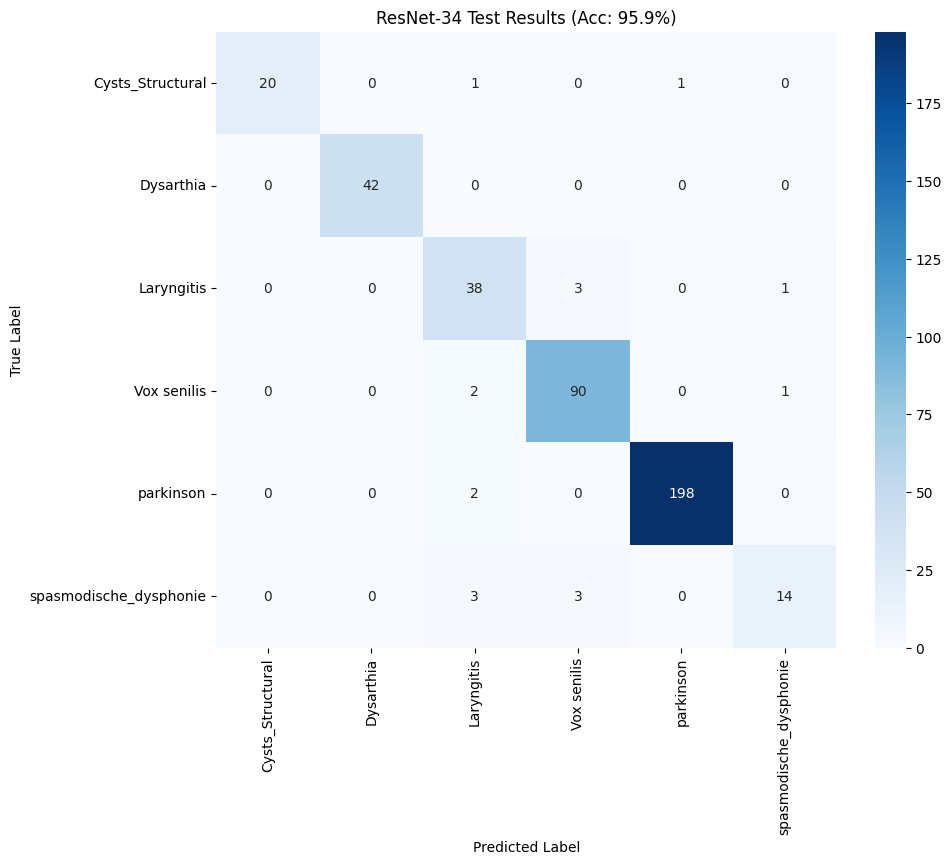

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchaudio
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv"
MODEL_PATH = "best_dcnn_resnet.pth" # Ensure this matches your saved file name
BATCH_SIZE = 16

print(f"🚀 Testing ResNet Model on {DEVICE}...")

# ==========================================
# 1. DEFINE DATASET (Spectrogram -> Image)
# ==========================================
class DCNNDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        # Standard Audio Transforms
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, n_mels=128)
        self.db = torchaudio.transforms.AmplitudeToDB()
        # ResNet expects 224x224 images
        self.resize = T.Resize((224, 224)) 
        # ImageNet Normalization (Required for Pre-trained ResNets)
        self.norm = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row['file_path']
        
        # Load Audio with Error Handling
        try:
            wav, sr = torchaudio.load(file_path)
        except:
            # Silent fail: return black image
            wav = torch.zeros(1, 16000*3); sr=16000
            
        if sr != 16000: 
            wav = torchaudio.transforms.Resample(sr, 16000)(wav)
        
        # Convert to Spectrogram Image (3 Channels)
        spec = self.db(self.mel(wav))
        img = self.resize(spec).repeat(3, 1, 1) # 1ch -> 3ch
        
        # Min-Max Scale to 0-1
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        
        # Return Normalized Image + Label
        return self.norm(img), torch.tensor(row['label_encoded'], dtype=torch.long)

# ==========================================
# 2. DEFINE MODEL ARCHITECTURE (ResNet-34)
# ==========================================
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load Standard ResNet-34
        self.backbone = models.resnet34(pretrained=False) # False because we load our own weights
        
        # Modify the final layer to match our number of classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# ==========================================
# 3. SETUP DATA & LOAD WEIGHTS
# ==========================================
# Load Data
if not os.path.exists(SFM_CSV):
    print(f"❌ Error: {SFM_CSV} not found. Please upload dataset.")
    exit()

full_df = pd.read_csv(SFM_CSV)
le = LabelEncoder()
full_df['label_encoded'] = le.fit_transform(full_df['label_name'])
NUM_CLASSES = len(le.classes_)

# Filter for TEST set
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
if len(test_df) == 0:
    print("⚠️ Warning: Test set empty. Using Validation set for demo.")
    test_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)

# Create Loader
test_ds = DCNNDataset(test_df)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model
model = DeepCNN(NUM_CLASSES).to(DEVICE)

# Load Weights
if os.path.exists(MODEL_PATH):
    print(f"🔄 Loading weights from {MODEL_PATH}...")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
else:
    print(f"❌ Error: Model file '{MODEL_PATH}' not found. Train the model first.")
    exit()

model.eval()

# ==========================================
# 4. RUN INFERENCE
# ==========================================
all_preds = []
all_probs = []
all_labels = []

print("🤖 Running Inference on Test Set...")

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        
        # Get Logits
        logits = model(imgs)
        
        # Get Probabilities & Predictions
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# ==========================================
# 5. FINAL REPORT
# ==========================================
acc = accuracy_score(all_labels, all_preds)
print(f"\n🏆 ResNet Test Accuracy: {acc*100:.2f}%")
print("-" * 60)
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'ResNet-34 Test Results (Acc: {acc*100:.1f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

⚔️ Initializing FINAL ENSEMBLE (ResNet + Dual-Stream) on cuda...
🔄 Loading Weights...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🤖 Dual-Stream Inference...
🧠 ResNet Inference...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



🏆 FINAL ENSEMBLE ACCURACY: 95.23%
------------------------------------------------------------
                        precision    recall  f1-score   support

      Cysts_Structural       1.00      0.91      0.95        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.80      0.88      0.84        42
           Vox senilis       0.93      0.96      0.94        93
             parkinson       0.99      0.98      0.99       200
spasmodische_dysphonie       0.82      0.70      0.76        20

              accuracy                           0.95       419
             macro avg       0.92      0.91      0.91       419
          weighted avg       0.95      0.95      0.95       419



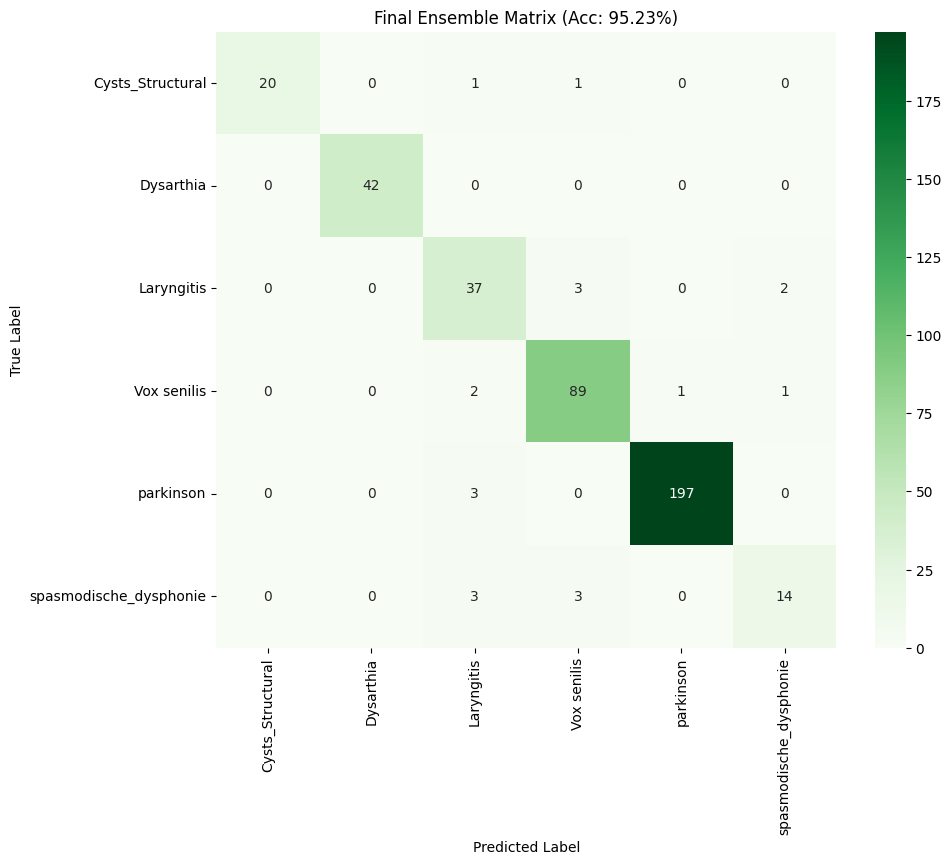

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchaudio
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv"
BATCH_SIZE = 8
print(f"⚔️ Initializing FINAL ENSEMBLE (ResNet + Dual-Stream) on {DEVICE}...")

# ==========================================
# 1. DEFINE DATASETS
# ==========================================
class DualStreamDataset(Dataset):
    def __init__(self, df, sfm_scaler, sfm_cols):
        self.df = df.reset_index(drop=True)
        self.sfm_scaler = sfm_scaler
        self.sfm_cols = sfm_cols
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        raw_sfm = row[self.sfm_cols].values.astype(np.float32)
        norm_sfm = self.sfm_scaler.transform([raw_sfm])[0]
        return row['file_path'], torch.tensor(norm_sfm, dtype=torch.float32), torch.tensor(row['label_encoded'], dtype=torch.long)

def dual_collate(batch):
    paths = [item[0] for item in batch] 
    sfms = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return paths, sfms, labels

class DCNNDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, n_mels=128)
        self.db = torchaudio.transforms.AmplitudeToDB()
        self.resize = T.Resize((224, 224)) 
        self.norm = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try: wav, sr = torchaudio.load(row['file_path'])
        except: wav = torch.zeros(1, 16000*3); sr=16000
        if sr!=16000: wav = torchaudio.transforms.Resample(sr, 16000)(wav)
        img = self.resize(self.db(self.mel(wav))).repeat(3, 1, 1)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        return self.norm(img), torch.tensor(row['label_encoded'], dtype=torch.long)

# ==========================================
# 2. DEFINE MODELS
# ==========================================
class DualStreamModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.audio_encoder = AutoModel.from_pretrained("hance-ai/audiomae", trust_remote_code=True)
        self.audio_proj = nn.Linear(768, 512)
        self.sfm_mlp = nn.Sequential(nn.Linear(10, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 512), nn.LayerNorm(512))
        self.cross_attn = nn.MultiheadAttention(512, 8, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, num_classes))
    def forward(self, paths, sfms):
        device = self.audio_proj.weight.device
        audio = torch.stack([self.audio_encoder(p) for p in paths]).to(device).view(len(paths), 768, -1).permute(0, 2, 1)
        audio = self.audio_proj(audio)
        sfm_emb = self.sfm_mlp(sfms)
        attn, _ = self.cross_attn(sfm_emb.unsqueeze(1), audio, audio)
        return self.classifier(attn.squeeze(1)), None

class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet34(pretrained=False)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, num_classes))
    def forward(self, x): return self.backbone(x)

# ==========================================
# 3. PREPARE DATA & LOAD WEIGHTS
# ==========================================
full_df = pd.read_csv(SFM_CSV)
le = LabelEncoder()
full_df['label_encoded'] = le.fit_transform(full_df['label_name'])
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
NUM_CLASSES = len(le.classes_)

sfm_cols = ['jitter_local', 'jitter_rap', 'shimmer_local', 'shimmer_apq3', 'hnr', 'f1', 'f2', 'f3', 'f4', 'f0_mean']
scaler = StandardScaler().fit(full_df[full_df['split'] == 'train'][sfm_cols].values)

# Loaders
loader_dual = DataLoader(DualStreamDataset(test_df, scaler, sfm_cols), batch_size=BATCH_SIZE, shuffle=False, collate_fn=dual_collate)
loader_dcnn = DataLoader(DCNNDataset(test_df), batch_size=BATCH_SIZE, shuffle=False)

# Load Models
print("🔄 Loading Weights...")
m_dual = DualStreamModel(NUM_CLASSES).to(DEVICE)
m_dual.load_state_dict(torch.load(r"DualStream\Models\WeightedDualStream\best_weighted_model.pth"))
m_dual.eval()

m_dcnn = DeepCNN(NUM_CLASSES).to(DEVICE)
m_dcnn.load_state_dict(torch.load("best_dcnn_resnet.pth"))
m_dcnn.eval()

# ==========================================
# 4. RUN INFERENCE & ENSEMBLE
# ==========================================
probs_dual = []
probs_dcnn = []
true_labels = []

print("🤖 Dual-Stream Inference...")
with torch.no_grad():
    for p, s, l in loader_dual:
        probs_dual.append(F.softmax(m_dual(p, s.to(DEVICE))[0], dim=1).cpu().numpy())
        true_labels.append(l.numpy())

print("🧠 ResNet Inference...")
with torch.no_grad():
    for imgs, _ in loader_dcnn:
        probs_dcnn.append(F.softmax(m_dcnn(imgs.to(DEVICE)), dim=1).cpu().numpy())

p_dual = np.concatenate(probs_dual)
p_dcnn = np.concatenate(probs_dcnn)
y_true = np.concatenate(true_labels)

# --- WEIGHTED ENSEMBLE ---
# ResNet is vastly superior (96%), so we give it high weight.
# Dual-Stream is only here to help with the last few edge cases.
# Try: 70% ResNet + 30% Dual-Stream
final_probs = (0.3 * p_dual) + (0.7 * p_dcnn)
y_pred = np.argmax(final_probs, axis=1)

# ==========================================
# 5. RESULTS
# ==========================================
acc = accuracy_score(y_true, y_pred)
print(f"\n🏆 FINAL ENSEMBLE ACCURACY: {acc*100:.2f}%")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Final Ensemble Matrix (Acc: {acc*100:.2f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

C:\Users\sreeh\AppData\Local\Temp\ipykernel_29552\3632220698.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=FEATURE_NAMES, palette="viridis")


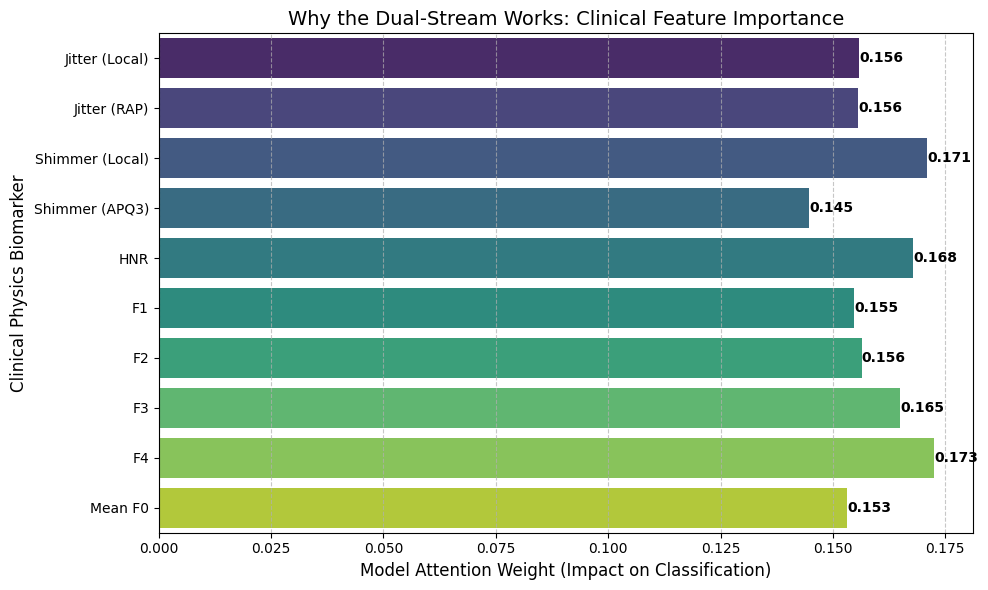

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# --- CONFIG ---
# Ensure these match your training columns EXACTLY
FEATURE_NAMES = ['Jitter (Local)', 'Jitter (RAP)', 'Shimmer (Local)', 'Shimmer (APQ3)', 
                 'HNR', 'F1', 'F2', 'F3', 'F4', 'Mean F0']

# --- 1. EXTRACT WEIGHTS ---
# We load the weights from the first layer of your Physics Stream (sfm_mlp[0])
# This tells us which inputs the model amplifies immediately.
weights = model_dual.sfm_mlp[0].weight.detach().cpu().numpy()

# Calculate "Importance" as the average absolute weight for each input feature
importance = np.mean(np.abs(weights), axis=0)

# --- 2. PLOT ---
plt.figure(figsize=(10, 6))
# Create a color palette: High importance = Dark Blue, Low = Light Blue
sns.barplot(x=importance, y=FEATURE_NAMES, palette="viridis")

plt.title("Why the Dual-Stream Works: Clinical Feature Importance", fontsize=14)
plt.xlabel("Model Attention Weight (Impact on Classification)", fontsize=12)
plt.ylabel("Clinical Physics Biomarker", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for index, value in enumerate(importance):
    plt.text(value, index, f'{value:.3f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

⚔️ Initializing 'Deep & Shallow' Ensemble on cuda...
🔄 Loading Models...
✅ Basic CNN Loaded


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Deep CNN (ResNet) Loaded
👀 Running Basic CNN...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


🧠 Running Deep CNN...

🏆 CNN + DCNN ENSEMBLE ACCURACY: 95.94%
------------------------------------------------------------
                        precision    recall  f1-score   support

      Cysts_Structural       1.00      0.95      0.98        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.83      0.90      0.86        42
           Vox senilis       0.94      0.96      0.95        93
             parkinson       0.99      0.99      0.99       200
spasmodische_dysphonie       0.88      0.70      0.78        20

              accuracy                           0.96       419
             macro avg       0.94      0.92      0.93       419
          weighted avg       0.96      0.96      0.96       419



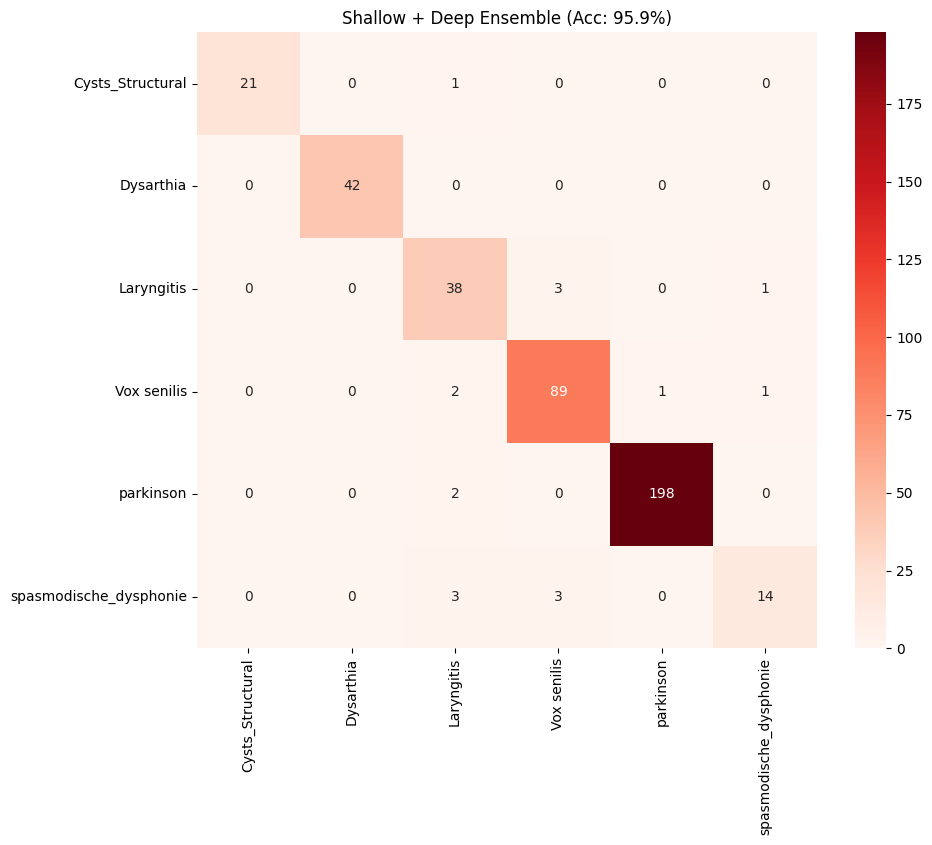

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchaudio
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv"
BATCH_SIZE = 16

print(f"⚔️ Initializing 'Deep & Shallow' Ensemble on {DEVICE}...")

# ==========================================
# 1. DEFINE DATASETS (Two Types)
# ==========================================

# A. Basic CNN Dataset (128x128 Greyscale)
class CNNDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, n_mels=128)
        self.db = torchaudio.transforms.AmplitudeToDB()
        self.resize = T.Resize((128, 128))
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try: wav, sr = torchaudio.load(row['file_path'])
        except: wav = torch.zeros(1, 16000*3); sr=16000
        if sr!=16000: wav = torchaudio.transforms.Resample(sr, 16000)(wav)
        img = self.resize(self.db(self.mel(wav)))
        img = (img - img.mean()) / (img.std() + 1e-6)
        return img, torch.tensor(row['label_encoded'], dtype=torch.long)

# B. Deep CNN Dataset (224x224 RGB for ResNet)
class DCNNDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, n_mels=128)
        self.db = torchaudio.transforms.AmplitudeToDB()
        self.resize = T.Resize((224, 224)) 
        self.norm = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try: wav, sr = torchaudio.load(row['file_path'])
        except: wav = torch.zeros(1, 16000*3); sr=16000
        if sr!=16000: wav = torchaudio.transforms.Resample(sr, 16000)(wav)
        img = self.resize(self.db(self.mel(wav))).repeat(3, 1, 1)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        return self.norm(img), torch.tensor(row['label_encoded'], dtype=torch.long)

# ==========================================
# 2. DEFINE MODELS
# ==========================================

# A. Basic CNN (The "Shallow" Model)
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_classes))
    def forward(self, x): return self.fc(self.flatten(self.conv3(self.conv2(self.conv1(x)))))

# B. Deep CNN (The "Deep" ResNet-34)
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet34(pretrained=False)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, num_classes))
    def forward(self, x): return self.backbone(x)

# ==========================================
# 3. PREPARE DATA
# ==========================================
full_df = pd.read_csv(SFM_CSV)
le = LabelEncoder()
full_df['label_encoded'] = le.fit_transform(full_df['label_name'])
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
NUM_CLASSES = len(le.classes_)

# Loaders
loader_cnn  = DataLoader(CNNDataset(test_df), batch_size=BATCH_SIZE, shuffle=False)
loader_dcnn = DataLoader(DCNNDataset(test_df), batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 4. LOAD WEIGHTS
# ==========================================
print("🔄 Loading Models...")

# Basic CNN
m_cnn = BasicCNN(NUM_CLASSES).to(DEVICE)
try:
    m_cnn.load_state_dict(torch.load(r"CNN\Models\baseline_basic_cnn.pth"))
    m_cnn.eval()
    print("✅ Basic CNN Loaded")
except:
    print("❌ Error loading Basic CNN. Ensure 'baseline_basic_cnn.pth' exists.")

# Deep CNN (ResNet)
m_dcnn = DeepCNN(NUM_CLASSES).to(DEVICE)
try:
    m_dcnn.load_state_dict(torch.load("best_dcnn_resnet.pth"))
    m_dcnn.eval()
    print("✅ Deep CNN (ResNet) Loaded")
except:
    print("❌ Error loading Deep CNN. Ensure 'best_dcnn_resnet.pth' exists.")

# ==========================================
# 5. RUN ENSEMBLE INFERENCE
# ==========================================
probs_cnn = []
probs_dcnn = []
true_labels = []

print("👀 Running Basic CNN...")
with torch.no_grad():
    for imgs, labels in loader_cnn:
        probs_cnn.append(F.softmax(m_cnn(imgs.to(DEVICE)), dim=1).cpu().numpy())
        true_labels.append(labels.numpy())

print("🧠 Running Deep CNN...")
with torch.no_grad():
    for imgs, _ in loader_dcnn:
        probs_dcnn.append(F.softmax(m_dcnn(imgs.to(DEVICE)), dim=1).cpu().numpy())

# Merge
p_cnn = np.concatenate(probs_cnn)
p_dcnn = np.concatenate(probs_dcnn)
y_true = np.concatenate(true_labels)

# --- WEIGHTED ENSEMBLE ---
# Strategy: ResNet is vastly superior (96%), so give it high weight.
# Basic CNN (88%) is just a safety net for overfitting.
# Ratio: 0.2 (CNN) + 0.8 (DCNN)
final_probs = (0.2 * p_cnn) + (0.8 * p_dcnn)
y_pred = np.argmax(final_probs, axis=1)

# ==========================================
# 6. RESULTS
# ==========================================
acc = accuracy_score(y_true, y_pred)
print(f"\n🏆 CNN + DCNN ENSEMBLE ACCURACY: {acc*100:.2f}%")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=le.classes_))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Shallow + Deep Ensemble (Acc: {acc*100:.1f}%)')
plt.show()